Alert! Animal herd detected nearbysuccesfully: Distance: 295.65 meters
Alert! Animal herd detected nearbysuccesfully: Distance: 881.92 meters
Alert! Animal herd detected nearbysuccesfully: Distance: 759.32 meters
Alert! Animal herd detected nearbysuccesfully: Distance: 975.63 meters
Alert! Animal herd detected nearbysuccesfully: Distance: 988.16 meters
Alert! Animal herd detected nearbysuccesfully: Distance: 906.82 meters
Alert! Animal herd detected nearbysuccesfully: Distance: 1410.10 meters
Alert! Animal herd detected nearbysuccesfully: Distance: 447.21 meters
Alert! Animal herd detected nearbysuccesfully: Distance: 189.16 meters
Alert! Animal herd detected nearbysuccesfully: Distance: 345.59 meters
Alert! Animal herd detected nearbysuccesfully: Distance: 165.60 meters
Alert! Animal herd detected nearbysuccesfully: Distance: 852.07 meters
Alert! Animal herd detected nearbysuccesfully: Distance: 571.28 meters


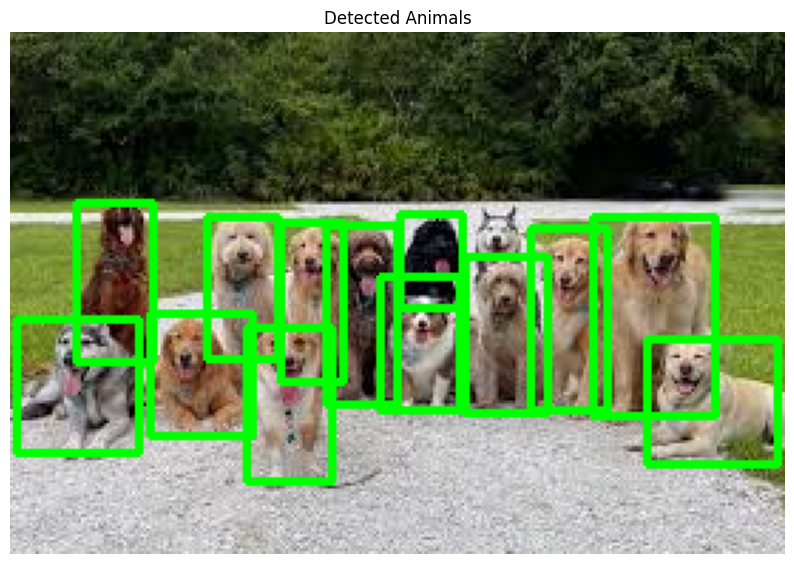

In [ ]:
import cv2
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import folium
import re
net = cv2.dnn.readNet(r"C:\Users\M.A Computer\Desktop\animal herd detection\lab6\yolov3.weights", 
                      r"C:\Users\M.A Computer\Desktop\animal herd detection\lab6\yolov3.cfg")
layersnames = net.getLayerNames()
output_layers = [layersnames[i - 1] for i in net.getUnconnectedOutLayers()]
with open("animal.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
def animals_detect(frame):
    height, width, channels = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and classes[class_id] == "dog": 
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    return boxes, indexes
def calculate_the_distance(loc1, loc2):
    return geodesic(loc1, loc2).meters
def send_alert(distance):
    print(f"Alert! Animal herd detected nearbysuccesfully: Distance: {distance:.2f} meters")
def extract_coordinates_from_place_link(link):
    match = re.search(r"@(-?\d+\.\d+),(-?\d+\.\d+)", link)
    if match:
        return float(match.group(1)), float(match.group(2))
    else:
        raise ValueError(" Google Maps place link is invalid. Please provide a valid link.")
herd_locations = []  

location_input = input("Enter your location (Google Maps place link or latitude,longitude):https://maps.app.goo.gl/pRPJumFonkYnpSLg9")

if "google.com/maps/place" in location_input:
    current_location = extract_coordinates_from_place_link(location_input)
else:
    try:
        lat, lon = list(__builtins__.map(float, location_input.split(','))) 
        current_location = (lat, lon)
    except ValueError:
        print("Invalid input. Please provide a valid Google Maps place link or latitude,longitude.")
        exit()
image_path = r"dog.jpg"  
frame = cv2.imread(image_path)

if frame is None:
    print("Error: Could not load image")
else:
    boxes, indexes = animals_detect(frame)
    for i in range(len(boxes)):
        if i in indexes:
            herd_lat = current_location[0] + np.random.uniform(-0.01, 0.01)  
            herd_lon = current_location[1] + np.random.uniform(-0.01, 0.01)  
            herd_locations.append((herd_lat, herd_lon))
            distance = calculate_the_distance(current_location, (herd_lat, herd_lon))
            send_alert(distance)
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.title("Detected Animals")
    plt.show()
    folium_map = folium.Map(location=current_location, zoom_start=15)
    folium.Marker(
        location=current_location,
        popup="Your Location",
        icon=folium.Icon(color="blue")
    ).add_to(folium_map)
    for herd_loc in herd_locations:
        folium.Circle(
            location=herd_loc,
            radius=50, 
            color="red",
            fill=True,
            fill_color="red",
            popup=f"Herd Location: {herd_loc}"
        ).add_to(folium_map)
    display(folium_map)